# Main

In [1]:
"""Scripts for analyzing of phantom outputs.

This script analysis the json files output by the main script to create a plot of the photosphere cross-section.
"""

'Scripts for analyzing of phantom outputs.\n\nThis script analysis the json files output by the main script to create a plot of the photosphere cross-section.\n'

## Imports & Settings

In [2]:
#%matplotlib inline
import math
import numpy as np
from numpy import pi
#import pandas
from astropy import units
from astropy import constants as const
import matplotlib.pyplot as plt
import matplotlib as mpl
from moviepy.editor import ImageSequenceClip
#import json
from os import path

In [3]:
# import modules listed in ./lib/

from main import clmuphantomlib as mupl

    # write metadata input
    
    metadata = {
        'Title'      : "",
        'Description': "",
        'Creator'    : "Chunliang Mu",
        'ORCiD'      : "https://orcid.org/0000-0003-1848-6507",
        'Affiliation': "Macquarie University",
        'Project'    : "[PhD Project] Radiative Transfer (RT) in Common Envelope Evolution (CEE)",
        'Supervisors': "Professor Orsola De Marco, Professor Mark Wardle",
    }
    with open("_metadata__input.json", 'w') as f:
        mupl.json_dump(metadata, f, metadata=None)

    # parallels & optimizations
    
    
    #import os
    ## Fixing stupid numba killing kernel
    ## See here https://github.com/numba/numba/issues/3016
    #os.environ['NUMBA_DISABLE_INTEL_SVML']  = '1'
    #from numba import njit, prange
    
    
    from multiprocessing import cpu_count, Pool
    
    NPROCESSES = cpu_count()
    if NPROCESSES is None:
        NPROCESSES = 1
    NPROCESSES = max(NPROCESSES, 1)


In [5]:
# settings
#
#   imported from script_input.py file

from script_PhLocCircles import plot_mpdf_photosphere_xsec
from script_PhLocCircles__input import verbose, PHOTOSPHERE_TAU, JOB_PROFILES, JOB_PROFILES_LIST
from script_PhLocCircles__input import ray_no, plane_axes_list, box_lim_dict, fps, unitsOut, use_saved_jsons

#JOB_PROFILES = JOB_PROFILES_LIST[:2]

unitsOutTxt = {}
for key in ['dist']:
    unitsOutTxt[key] = unitsOut[key].to_string('latex')


    
    
#file_indexes_dict = {
#    '../photosphere/luis_2md/light': (1200, 2000, 2800, 4700, 5800),  # 1188, 1980, 4710, 5780, 7090, 8000,
#    '../photosphere/luis_4md/light': (1200, 2000, 2800, 4700, 5800),  # 1188, 1980, 2772, 3564, 4710, 5780
#}
file_indexes_dict = {job_profile['job_name']: (1200, 2000, 2800, 4700, 5800) for job_profile in JOB_PROFILES}

outfilename_prefix = {
    '../photosphere/luis_2md/light': '2md',
    '../photosphere/luis_4md/light': '4md',
    '../photosphere/miguel_2m/binary': '2m',
    '../photosphere/miguel_4m/binary': '4m',
    '../photosphere/miguel_2m_2022/binary': '2m-2022',
}



plt.rcParams.update({'font.size': 20})


# print debug info
if verbose >= 2:
    #print(f"   Note: Will use {NPROCESSES} processes for parallelization")
    pass
    

metadata = {'Title': 'Getting photosphere cross-section on a 2D plane', 'Description': "Tracing 600 of rays on ['xy', 'xz'] planes.\nphotosphere is defined as where optical depth reaches 1.0.\n\n*   Note: ['ph_vars']['loc'] is in the order of ['ph_vars']['plane_axes'],\n        I.e. if ['ph_vars']['plane_axes'] is 'xzy',\n        then ['ph_vars']['loc'] is recorded in order of x, z, y coordinates!\n", 'Creator': 'Chunliang Mu', 'CreatorEmail': 'chunliang.mu@hdr.mq.edu.au', 'ORCiD': 'https://orcid.org/0000-0003-1848-6507', 'Affiliation': 'Macquarie University', 'Project': '[PhD Project] Radiative Transfer (RT) in Common Envelope Evolution (CEE)', 'PrincipalSupervisor': 'Professor Orsola De Marco', 'AssociateSupervisor': 'Professor Mark Wardle'}
   Note: Will use 8 processes for parallelization


In [7]:
box_lim_dict

{'2md': 199, '4md': 199, '2m': 39, '4m': 39, '2m_2022': 39}

# Analysis

## Get photosphere locations

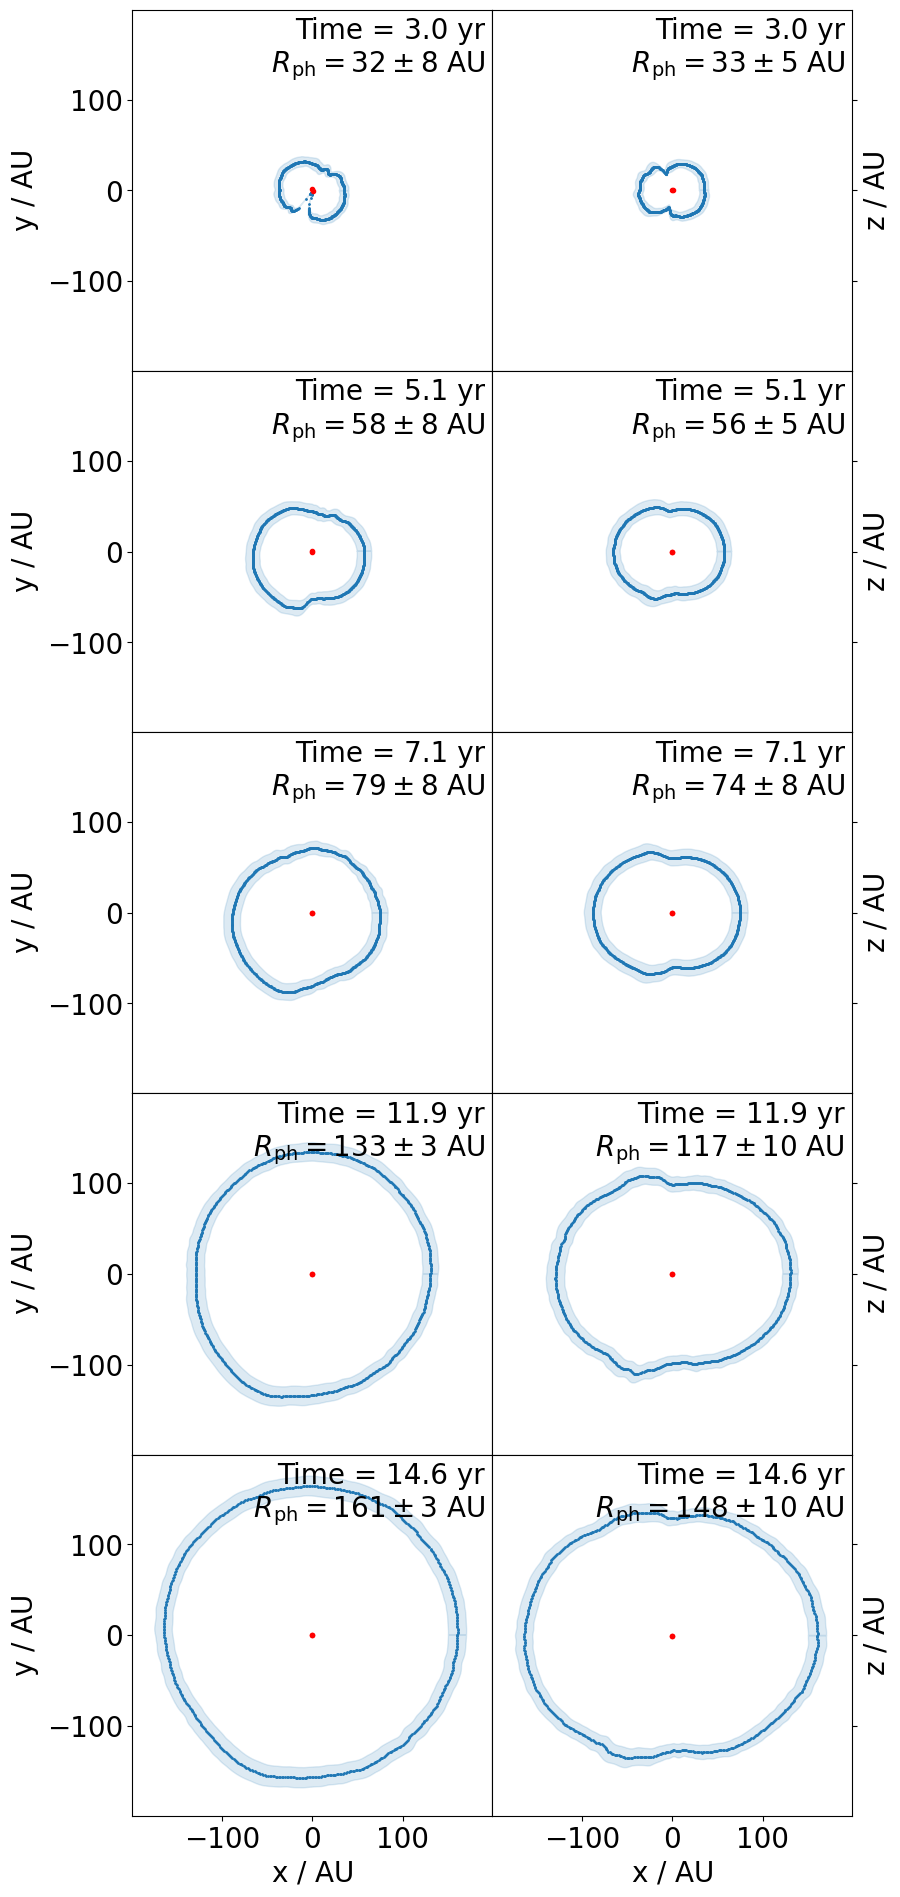

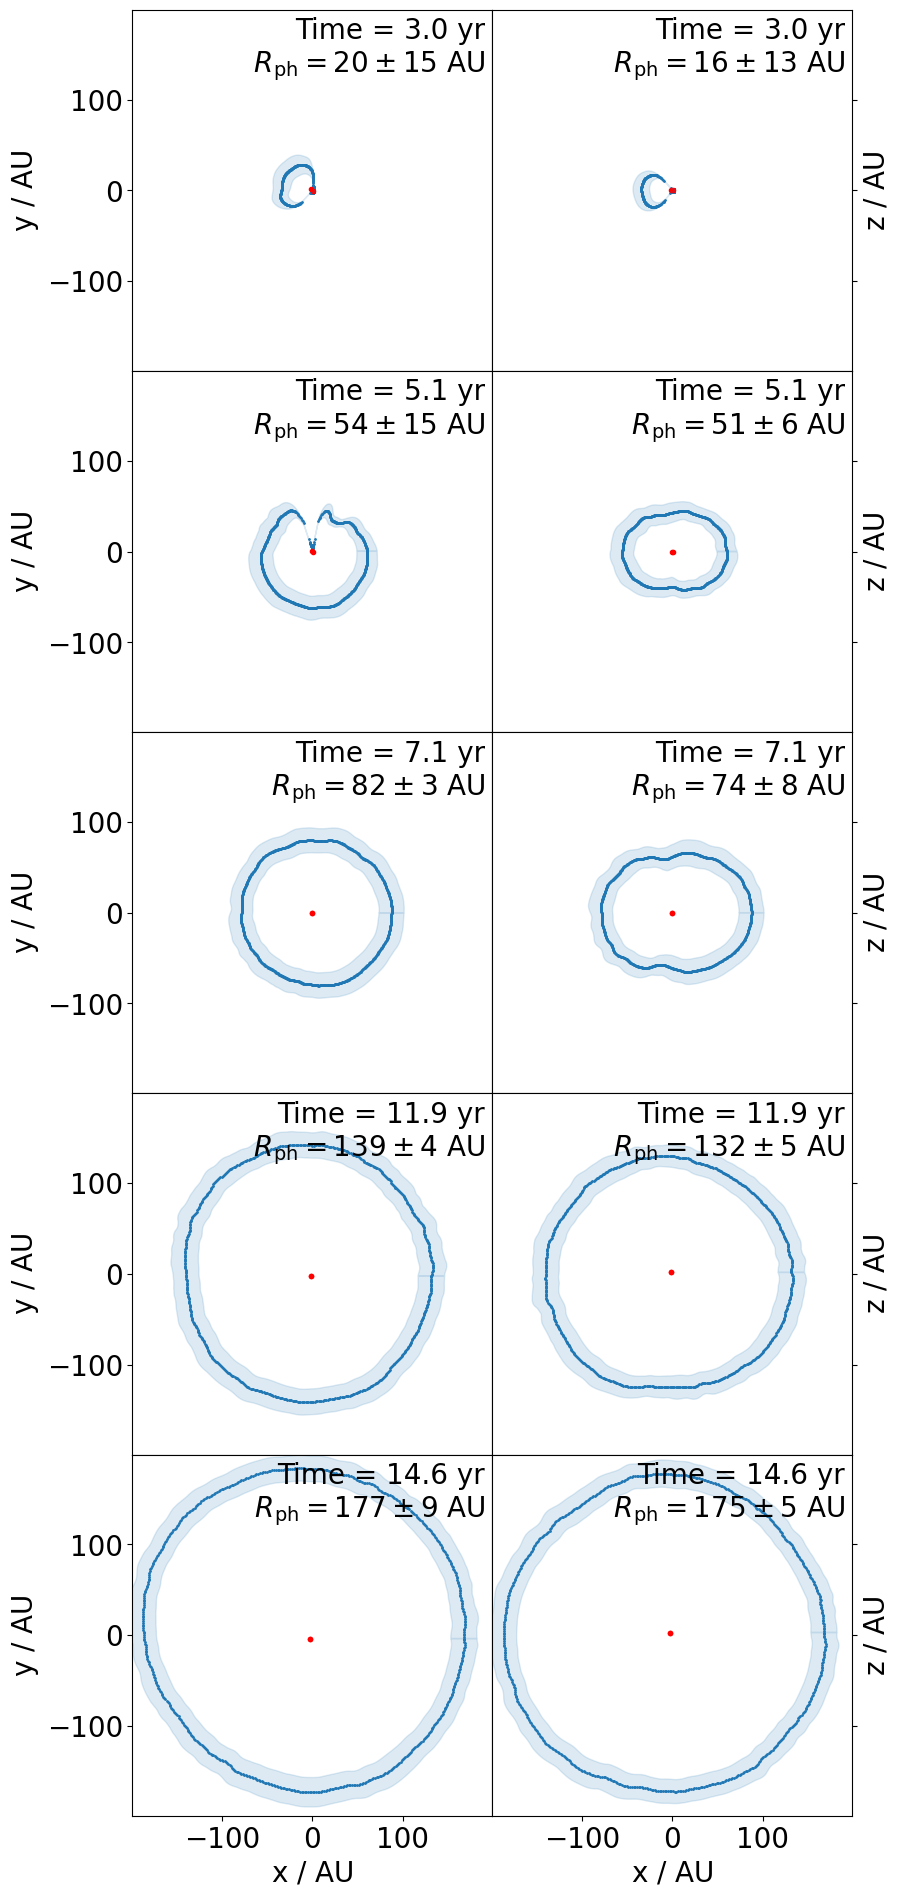

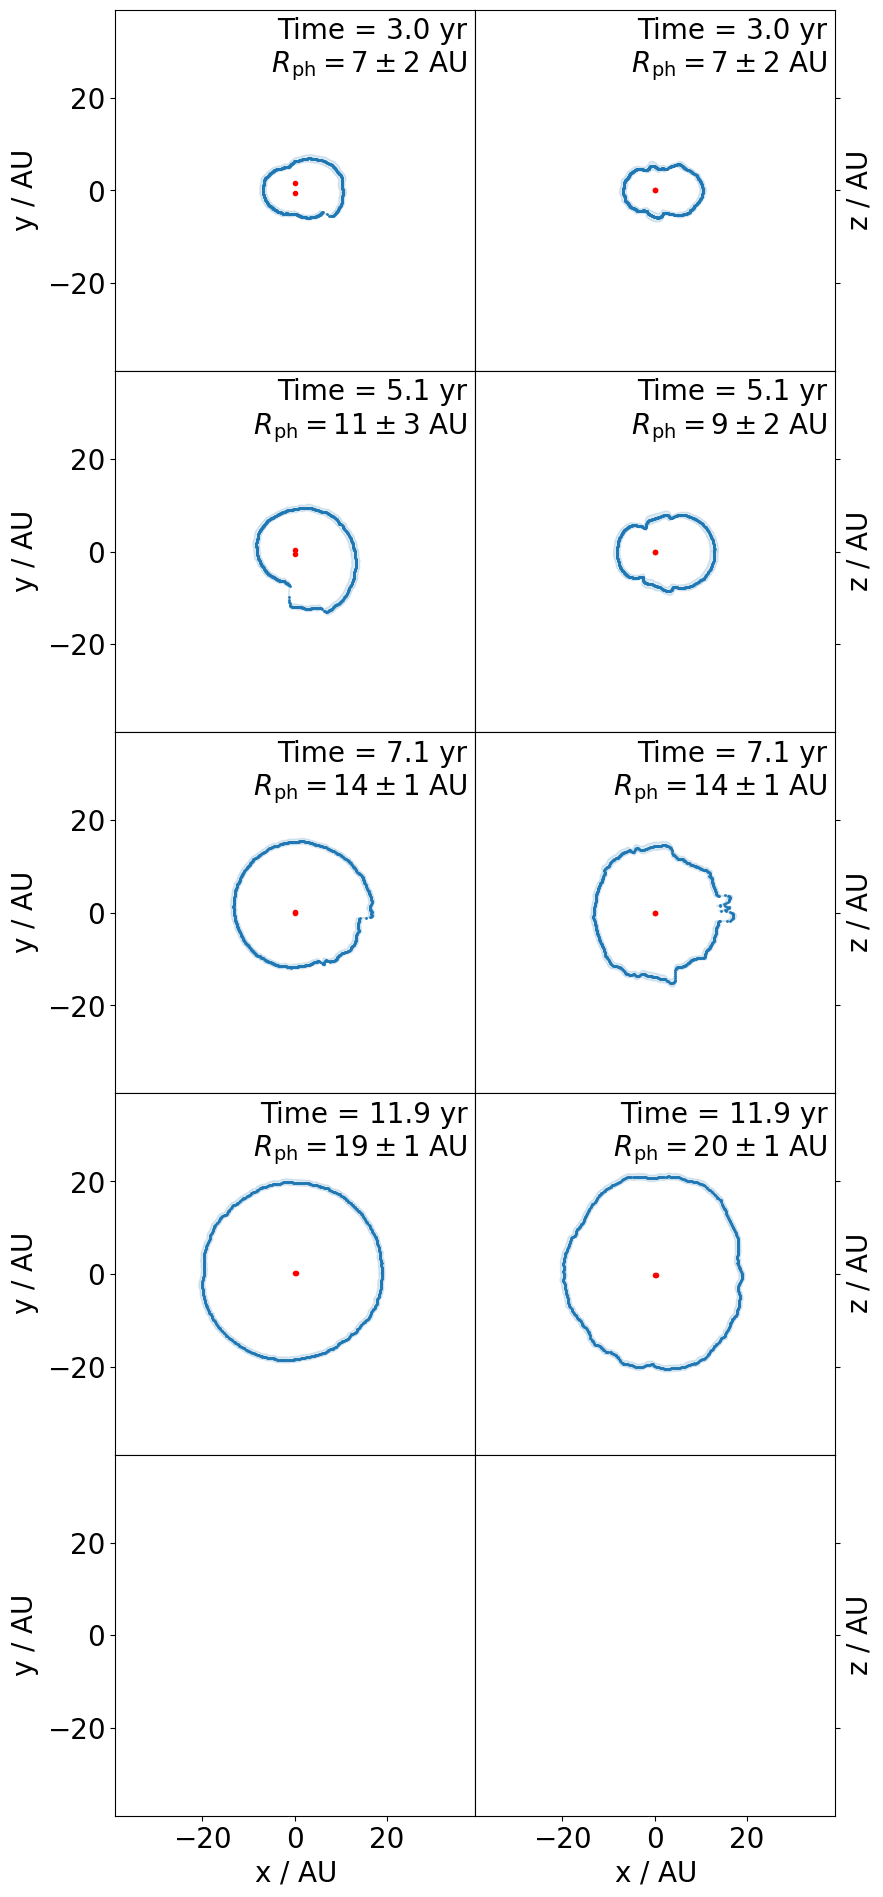

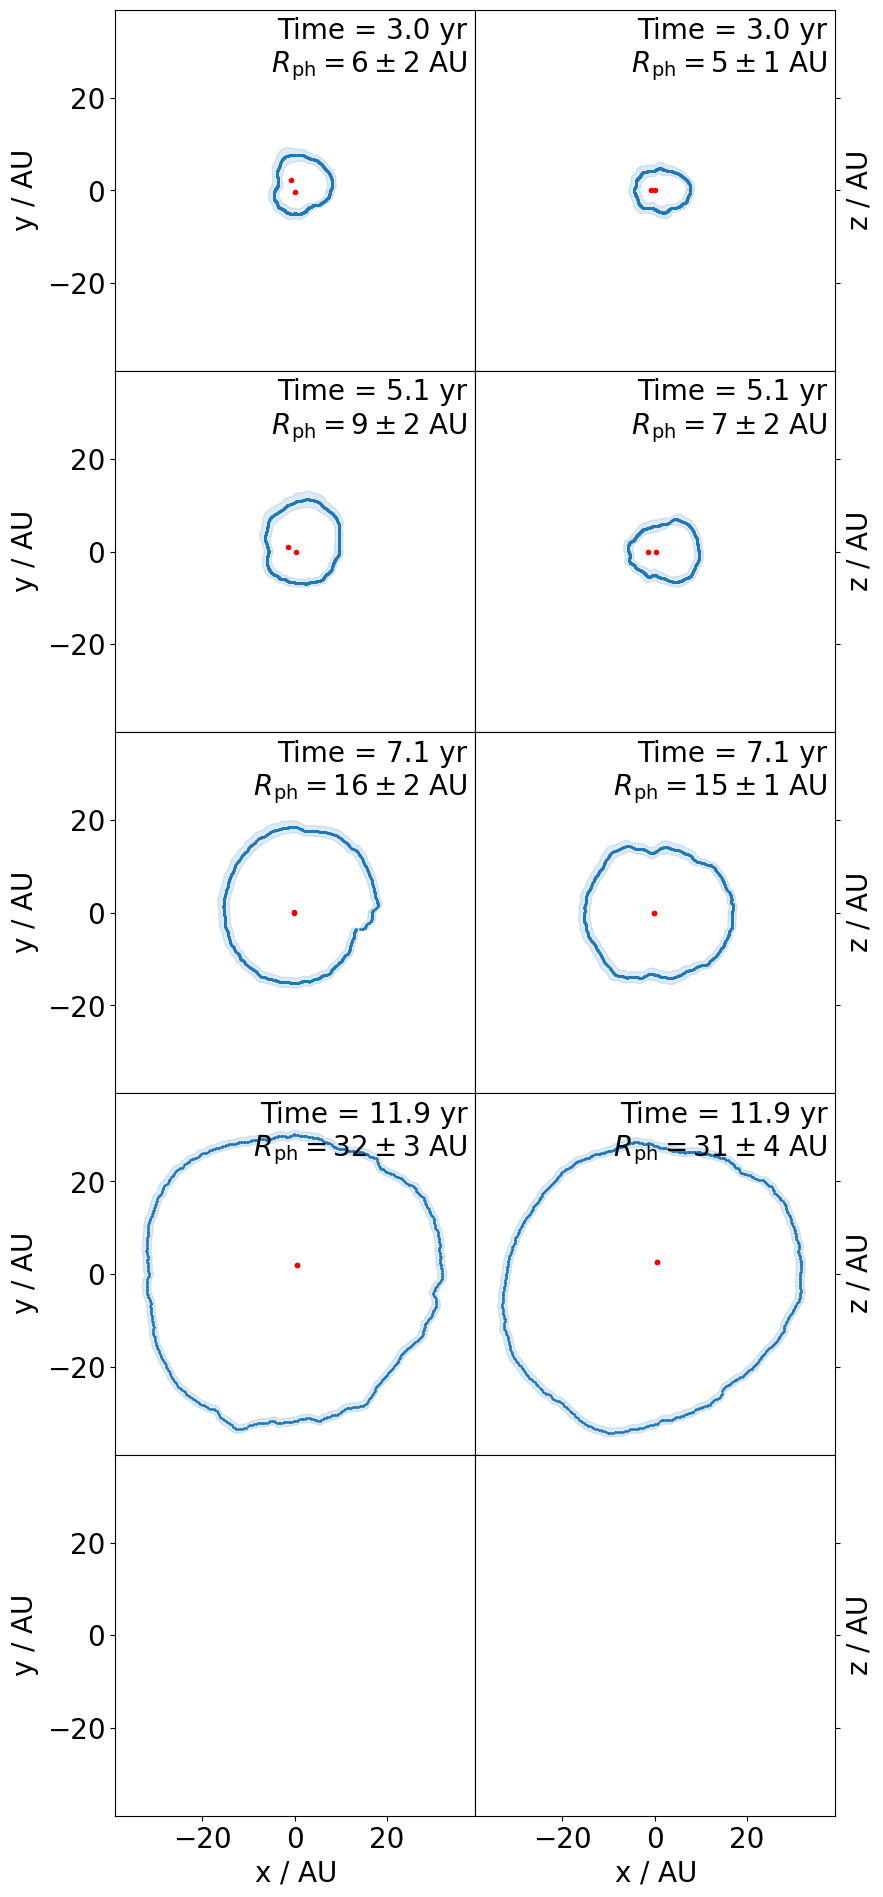

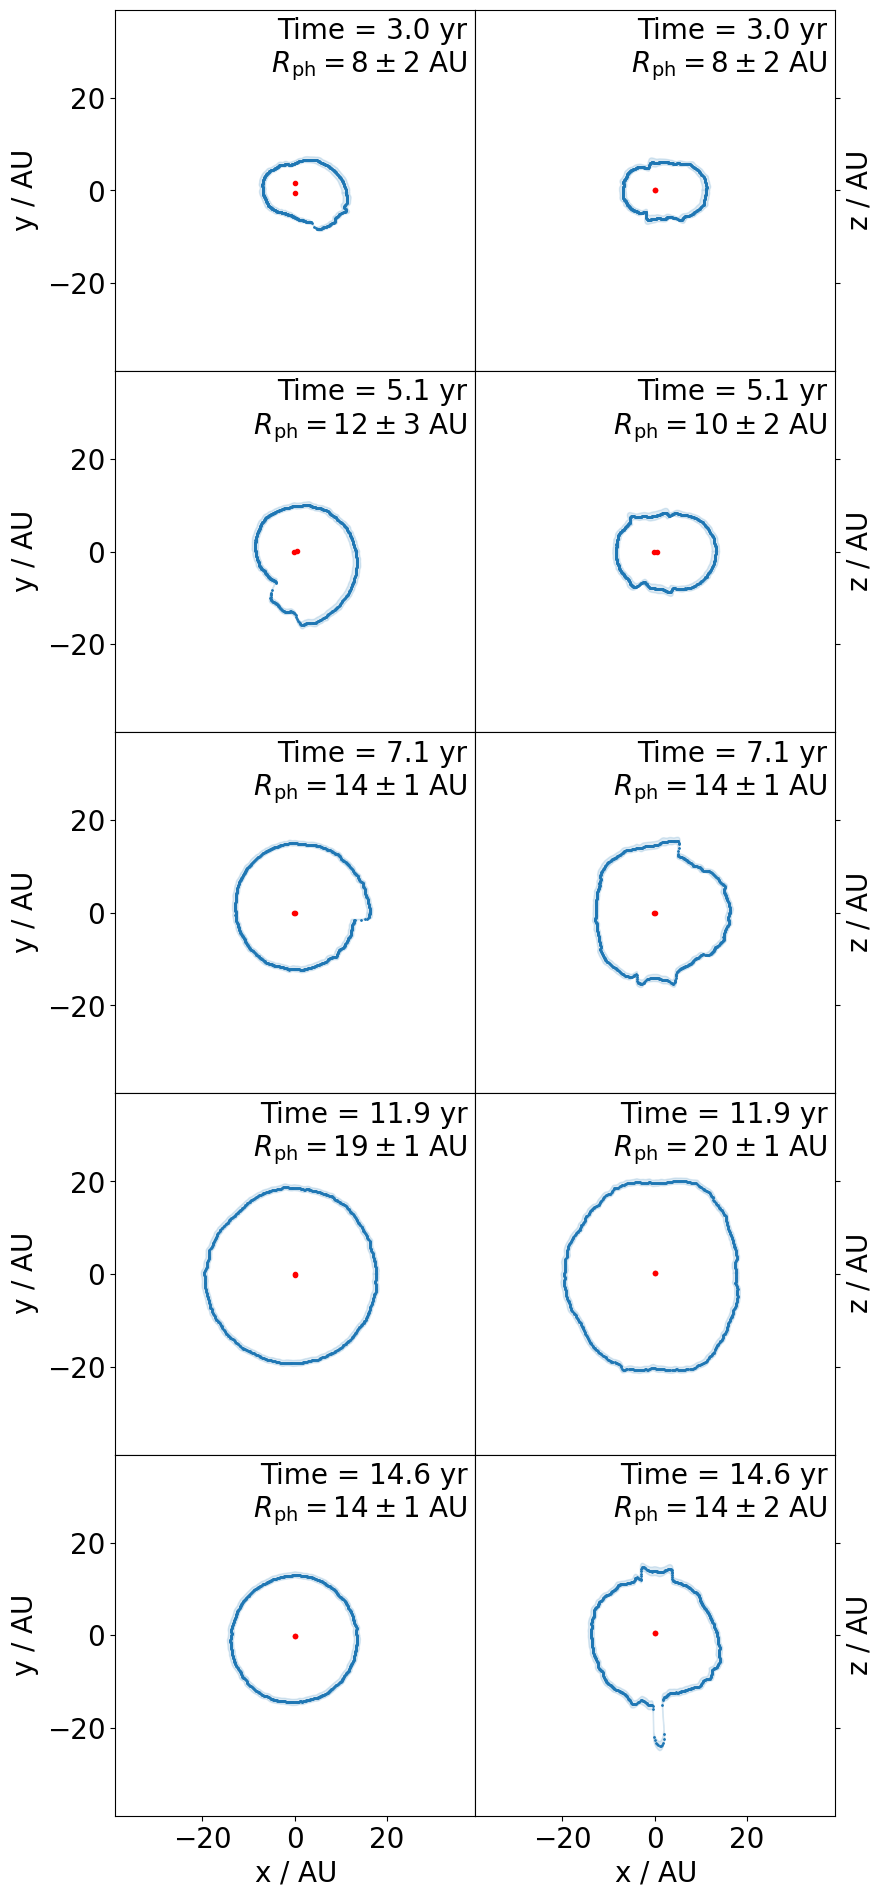

In [11]:
# main process


if __name__ == '__main__':
        
    # plotting selected slices for both xy & xz at the same time
    
    
    for job_profile in JOB_PROFILES:
        #job_profile = JOB_PROFILES[0]
        
        job_name = job_profile['job_name']
        plot_title_suffix=job_profile['plot_title_suffix']

        box_lim = box_lim_dict[job_profile['nickname']]
        xlim = (-box_lim, box_lim)
        ylim = xlim
    
        # init
        outfilenames_dict = {}
        for plane_axes in plane_axes_list:
            outfilenames_dict[plane_axes] = []
        
        file_indexes = file_indexes_dict[job_name]
        
        
        nrow = len(file_indexes)
        ncol = len(plane_axes_list)
        fig, axes = plt.subplots(nrow, ncol, figsize=(1+ncol*4, 1+nrow*4), sharex=True, sharey=True)
        fig.subplots_adjust(left=0.15, right=0.95, bottom=0.09, top=0.95, hspace=0.0, wspace=0.0)
            
        # main
        for axes_col, file_index in zip(axes, file_indexes):
            job_filename = mupl.get_filename_phantom_dumps(job_name, file_index)
            for ax, plane_axes in zip(axes_col, plane_axes_list):
                try:
                    with open(f"{job_filename}__photosphere-xsec__R1-{plane_axes}.json", 'r') as f:
                        photospheres = mupl.readwrite.json_load(f)
                except FileNotFoundError:
                    print(f"Warning: File for {job_filename} does not exist.")
                else:
                    plot_mpdf_photosphere_xsec(
                        photospheres,
                        job_name, file_index, plot_title_suffix,
                        ax=ax,
                        do_legend=False, box_lim=box_lim, unitsOut=unitsOut,
                        outfilename_noext="",
                    )
    
        for axes_col in axes:
            axes_col[ 0].set_ylabel(f"{plane_axes_list[ 0][1]} / {unitsOutTxt['dist']}")
            axes_col[-1].set_ylabel(f"{plane_axes_list[-1][1]} / {unitsOutTxt['dist']}")
            axes_col[-1].yaxis.tick_right()
            axes_col[-1].yaxis.set_label_position('right')
        
        for ax in axes[-1]:
            ax.set_xlabel(f"{plane_axes[0]} / {unitsOutTxt['dist']}")
                
        outfilename_noext = f"fig__{outfilename_prefix[job_name]}__photosphere-xsec__R1"
        fig.savefig(f"{outfilename_noext}.pdf")
        fig.savefig(f"{outfilename_noext}.png")

../photosphere/luis_2md/light
../photosphere/luis_4md/light
../photosphere/miguel_2m/binary
../photosphere/miguel_4m/binary
../photosphere/miguel_2m_2022/binary


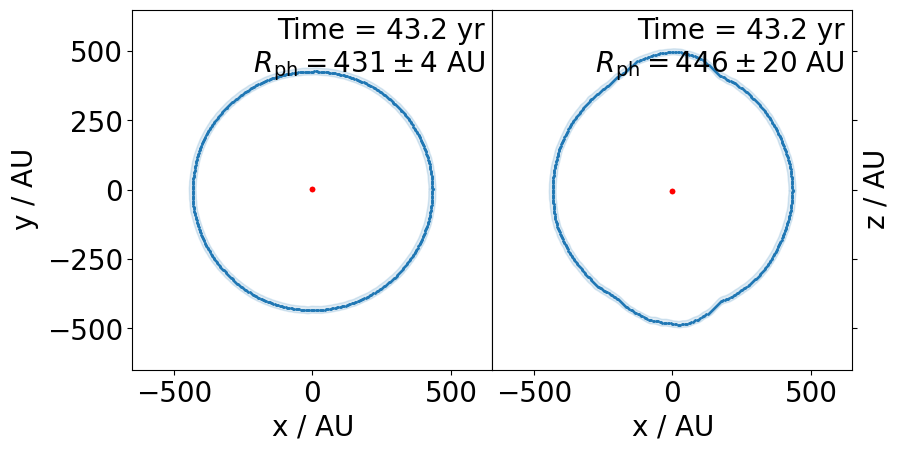

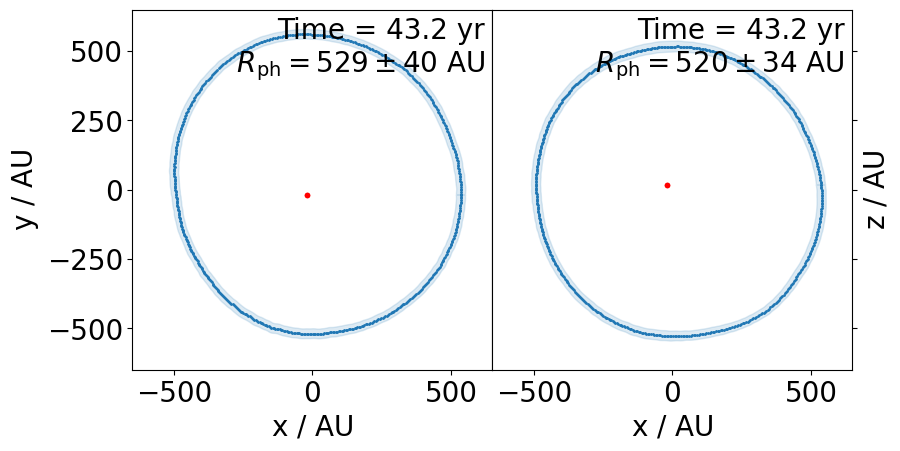

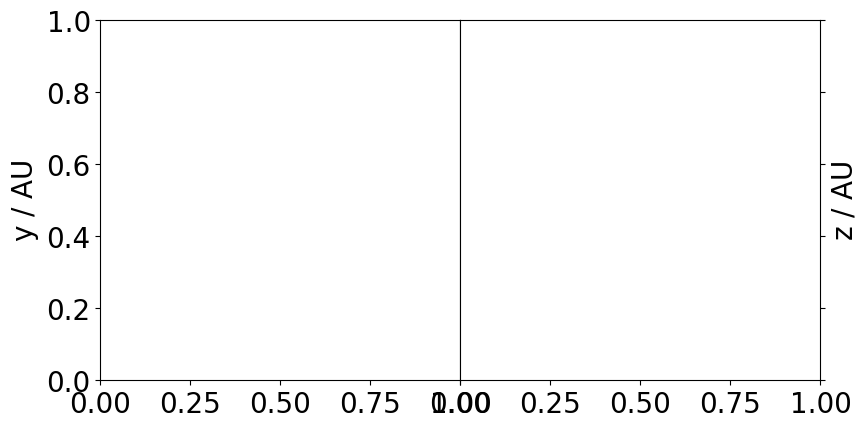

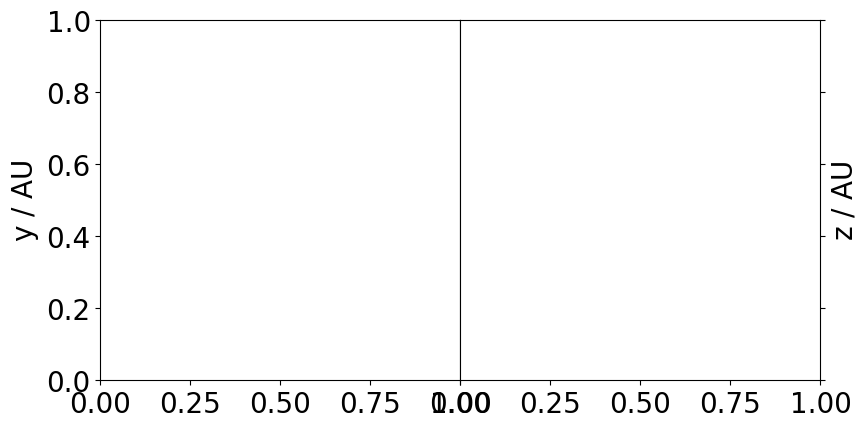

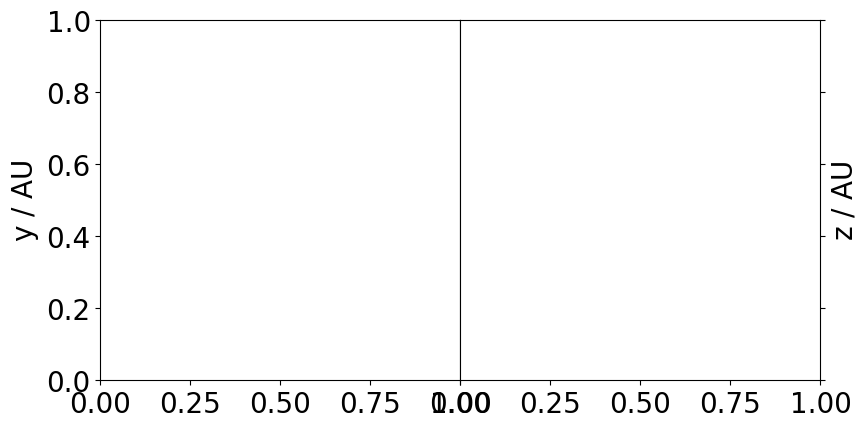

In [12]:
# main process
# plotting the ph xsec at the final years ( 40 yr )

if __name__ == '__main__':
        
    # plotting selected slices for both xy & xz at the same time

    box_lim_late = 649
    xlim = (-box_lim_late, box_lim_late)
    ylim = xlim
    file_index = 17100
    
    for job_profile in JOB_PROFILES:
        #job_profile = JOB_PROFILES[0]
        
        job_name = job_profile['job_name']
        plot_title_suffix=job_profile['plot_title_suffix']
        print(job_name)
        
    
        # init
        outfilenames_dict = {}
        for plane_axes in plane_axes_list:
            outfilenames_dict[plane_axes] = []
        
        
        #nrow = len(file_indexes)
        nrow = 1
        ncol = len(plane_axes_list)
        fig, axes = plt.subplots(nrow, ncol, figsize=(1+ncol*4, 1+nrow*4), sharex=True, sharey=True)
        fig.subplots_adjust(left=0.15, right=0.95, bottom=0.23, top=0.95, hspace=0.0, wspace=0.0)
            
        # main
        axes_col = axes
        if True:
            job_filename = mupl.get_filename_phantom_dumps(job_name, file_index)
            for ax, plane_axes in zip(axes_col, plane_axes_list):
                try:
                    with open(f"{job_filename}__photosphere-xsec__R1-{plane_axes}.json", 'r') as f:
                        photospheres = mupl.readwrite.json_load(f)
                except FileNotFoundError:
                    print(f"Warning: File for {job_filename} does not exist.")
                else:
                    plot_mpdf_photosphere_xsec(
                        photospheres,
                        job_name, file_index, plot_title_suffix,
                        ax=ax,
                        do_legend=False, box_lim=box_lim_late, unitsOut=unitsOut,
                        outfilename_noext="",
                    )
    
        #for axes_col in axes:
        if True:
            axes_col[ 0].set_ylabel(f"{plane_axes_list[ 0][1]} / {unitsOutTxt['dist']}")
            axes_col[-1].set_ylabel(f"{plane_axes_list[-1][1]} / {unitsOutTxt['dist']}")
            axes_col[-1].yaxis.tick_right()
            axes_col[-1].yaxis.set_label_position('right')
        
        #for ax in axes[-1]:
        #    ax.set_xlabel(f"{plane_axes[0]} / {unitsOutTxt['dist']}")
                
        outfilename_noext = f"fig__{outfilename_prefix[job_name]}__photosphere-xsec__R1-later"
        fig.savefig(f"{outfilename_noext}.pdf")
        fig.savefig(f"{outfilename_noext}.png")

## Making Movies

In [9]:
# main process


if __name__ == '__main__':
    
    for job_profile in JOB_PROFILES:
        job_name = job_profile['job_name']
        box_lim = box_lim_dict[job_profile['nickname']]

        outfilenames_dict = {}
        for plane_axes in plane_axes_list:
            outfilenames_dict[plane_axes] = []
        
        for file_index in job_profile['file_indexes']:
            # read data

        
            for plane_axes in plane_axes_list:
                outfilename_noext = f"{mupl.get_filename_phantom_dumps(job_name, file_index)}__photosphere-xsec__R1-{plane_axes}"
                with open(f"{outfilename_noext}.json", 'r') as f:
                    photospheres = mupl.json_load(f)
    
                fig, ax, outfilename = plot_mpdf_photosphere_xsec(
                    photospheres= photospheres,
                    job_name    = job_name,
                    job_index   = file_index,
                    plot_title_suffix=job_profile['plot_title_suffix'],
                    box_lim     = box_lim,
                    unitsOut    = unitsOut,
                    outfilename = f"{outfilename_noext}.png",
                )
                plt.close(fig)
                outfilenames_dict[plane_axes].append(outfilename)
                print(f"Done: {outfilename};")
    
        # Make movie
    
        for plane_axes in plane_axes_list:
            outfilename_vectxt = f"R1-{plane_axes}"
            with ImageSequenceClip(outfilenames_dict[plane_axes], fps=fps) as vid:
                moviefilename = f"{job_profile['job_name']}__photosphere-xsec__{outfilename_vectxt}__movie.mp4"
                vid.write_videofile(moviefilename)

    print("\n\n\n*** All Done. ***\n\n\n")

Done: ../photosphere/luis_2md/light_00000__photosphere-xsec__R1-xyz.png;
Done: ../photosphere/luis_2md/light_00000__photosphere-xsec__R1-xzy.png;
Done: ../photosphere/luis_2md/light_00100__photosphere-xsec__R1-xyz.png;
Done: ../photosphere/luis_2md/light_00100__photosphere-xsec__R1-xzy.png;
Done: ../photosphere/luis_2md/light_00200__photosphere-xsec__R1-xyz.png;
Done: ../photosphere/luis_2md/light_00200__photosphere-xsec__R1-xzy.png;
Done: ../photosphere/luis_2md/light_00300__photosphere-xsec__R1-xyz.png;
Done: ../photosphere/luis_2md/light_00300__photosphere-xsec__R1-xzy.png;
Done: ../photosphere/luis_2md/light_00400__photosphere-xsec__R1-xyz.png;
Done: ../photosphere/luis_2md/light_00400__photosphere-xsec__R1-xzy.png;
Done: ../photosphere/luis_2md/light_00500__photosphere-xsec__R1-xyz.png;
Done: ../photosphere/luis_2md/light_00500__photosphere-xsec__R1-xzy.png;
Done: ../photosphere/luis_2md/light_00600__photosphere-xsec__R1-xyz.png;
Done: ../photosphere/luis_2md/light_00600__photosph

Moviepy - Done !
Moviepy - video ready ../photosphere/luis_2md/light__photosphere-xsec__R1-xyz__movie.mp4
Moviepy - Building video ../photosphere/luis_2md/light__photosphere-xsec__R1-xzy__movie.mp4.
Moviepy - Writing video ../photosphere/luis_2md/light__photosphere-xsec__R1-xzy__movie.mp4



Moviepy - Done !
Moviepy - video ready ../photosphere/luis_2md/light__photosphere-xsec__R1-xzy__movie.mp4
Done: ../photosphere/luis_4md/light_00000__photosphere-xsec__R1-xyz.png;
Done: ../photosphere/luis_4md/light_00000__photosphere-xsec__R1-xzy.png;
Done: ../photosphere/luis_4md/light_00100__photosphere-xsec__R1-xyz.png;
Done: ../photosphere/luis_4md/light_00100__photosphere-xsec__R1-xzy.png;
Done: ../photosphere/luis_4md/light_00200__photosphere-xsec__R1-xyz.png;
Done: ../photosphere/luis_4md/light_00200__photosphere-xsec__R1-xzy.png;
Done: ../photosphere/luis_4md/light_00300__photosphere-xsec__R1-xyz.png;
Done: ../photosphere/luis_4md/light_00300__photosphere-xsec__R1-xzy.png;
Done: ../photosphere/luis_4md/light_00400__photosphere-xsec__R1-xyz.png;
Done: ../photosphere/luis_4md/light_00400__photosphere-xsec__R1-xzy.png;
Done: ../photosphere/luis_4md/light_00500__photosphere-xsec__R1-xyz.png;
Done: ../photosphere/luis_4md/light_00500__photosphere-xsec__R1-xzy.png;
Done: ../photosphe

Moviepy - Done !
Moviepy - video ready ../photosphere/luis_4md/light__photosphere-xsec__R1-xyz__movie.mp4
Moviepy - Building video ../photosphere/luis_4md/light__photosphere-xsec__R1-xzy__movie.mp4.
Moviepy - Writing video ../photosphere/luis_4md/light__photosphere-xsec__R1-xzy__movie.mp4



Moviepy - Done !
Moviepy - video ready ../photosphere/luis_4md/light__photosphere-xsec__R1-xzy__movie.mp4
Done: ../photosphere/miguel_2m/binary_00000__photosphere-xsec__R1-xyz.png;
Done: ../photosphere/miguel_2m/binary_00000__photosphere-xsec__R1-xzy.png;
Done: ../photosphere/miguel_2m/binary_00100__photosphere-xsec__R1-xyz.png;
Done: ../photosphere/miguel_2m/binary_00100__photosphere-xsec__R1-xzy.png;
Done: ../photosphere/miguel_2m/binary_00200__photosphere-xsec__R1-xyz.png;
Done: ../photosphere/miguel_2m/binary_00200__photosphere-xsec__R1-xzy.png;
Done: ../photosphere/miguel_2m/binary_00300__photosphere-xsec__R1-xyz.png;
Done: ../photosphere/miguel_2m/binary_00300__photosphere-xsec__R1-xzy.png;
Done: ../photosphere/miguel_2m/binary_00400__photosphere-xsec__R1-xyz.png;
Done: ../photosphere/miguel_2m/binary_00400__photosphere-xsec__R1-xzy.png;
Done: ../photosphere/miguel_2m/binary_00500__photosphere-xsec__R1-xyz.png;
Done: ../photosphere/miguel_2m/binary_00500__photosphere-xsec__R1-xzy

Moviepy - Done !
Moviepy - video ready ../photosphere/miguel_2m/binary__photosphere-xsec__R1-xyz__movie.mp4
Moviepy - Building video ../photosphere/miguel_2m/binary__photosphere-xsec__R1-xzy__movie.mp4.
Moviepy - Writing video ../photosphere/miguel_2m/binary__photosphere-xsec__R1-xzy__movie.mp4



Moviepy - Done !
Moviepy - video ready ../photosphere/miguel_2m/binary__photosphere-xsec__R1-xzy__movie.mp4
Done: ../photosphere/miguel_4m/binary_00000__photosphere-xsec__R1-xyz.png;
Done: ../photosphere/miguel_4m/binary_00000__photosphere-xsec__R1-xzy.png;
Done: ../photosphere/miguel_4m/binary_00100__photosphere-xsec__R1-xyz.png;
Done: ../photosphere/miguel_4m/binary_00100__photosphere-xsec__R1-xzy.png;
Done: ../photosphere/miguel_4m/binary_00200__photosphere-xsec__R1-xyz.png;
Done: ../photosphere/miguel_4m/binary_00200__photosphere-xsec__R1-xzy.png;
Done: ../photosphere/miguel_4m/binary_00300__photosphere-xsec__R1-xyz.png;
Done: ../photosphere/miguel_4m/binary_00300__photosphere-xsec__R1-xzy.png;
Done: ../photosphere/miguel_4m/binary_00400__photosphere-xsec__R1-xyz.png;
Done: ../photosphere/miguel_4m/binary_00400__photosphere-xsec__R1-xzy.png;
Done: ../photosphere/miguel_4m/binary_00500__photosphere-xsec__R1-xyz.png;
Done: ../photosphere/miguel_4m/binary_00500__photosphere-xsec__R1-x

Moviepy - Done !
Moviepy - video ready ../photosphere/miguel_4m/binary__photosphere-xsec__R1-xyz__movie.mp4
Moviepy - Building video ../photosphere/miguel_4m/binary__photosphere-xsec__R1-xzy__movie.mp4.
Moviepy - Writing video ../photosphere/miguel_4m/binary__photosphere-xsec__R1-xzy__movie.mp4



Moviepy - Done !
Moviepy - video ready ../photosphere/miguel_4m/binary__photosphere-xsec__R1-xzy__movie.mp4
Done: ../photosphere/miguel_2m_2022/binary_00000__photosphere-xsec__R1-xyz.png;
Done: ../photosphere/miguel_2m_2022/binary_00000__photosphere-xsec__R1-xzy.png;
Done: ../photosphere/miguel_2m_2022/binary_00100__photosphere-xsec__R1-xyz.png;
Done: ../photosphere/miguel_2m_2022/binary_00100__photosphere-xsec__R1-xzy.png;
Done: ../photosphere/miguel_2m_2022/binary_00200__photosphere-xsec__R1-xyz.png;
Done: ../photosphere/miguel_2m_2022/binary_00200__photosphere-xsec__R1-xzy.png;
Done: ../photosphere/miguel_2m_2022/binary_00300__photosphere-xsec__R1-xyz.png;
Done: ../photosphere/miguel_2m_2022/binary_00300__photosphere-xsec__R1-xzy.png;
Done: ../photosphere/miguel_2m_2022/binary_00400__photosphere-xsec__R1-xyz.png;
Done: ../photosphere/miguel_2m_2022/binary_00400__photosphere-xsec__R1-xzy.png;
Done: ../photosphere/miguel_2m_2022/binary_00500__photosphere-xsec__R1-xyz.png;
Done: ../pho

Moviepy - Done !
Moviepy - video ready ../photosphere/miguel_2m_2022/binary__photosphere-xsec__R1-xyz__movie.mp4
Moviepy - Building video ../photosphere/miguel_2m_2022/binary__photosphere-xsec__R1-xzy__movie.mp4.
Moviepy - Writing video ../photosphere/miguel_2m_2022/binary__photosphere-xsec__R1-xzy__movie.mp4



Moviepy - Done !
Moviepy - video ready ../photosphere/miguel_2m_2022/binary__photosphere-xsec__R1-xzy__movie.mp4



*** All Done. ***





## Temperature evolution

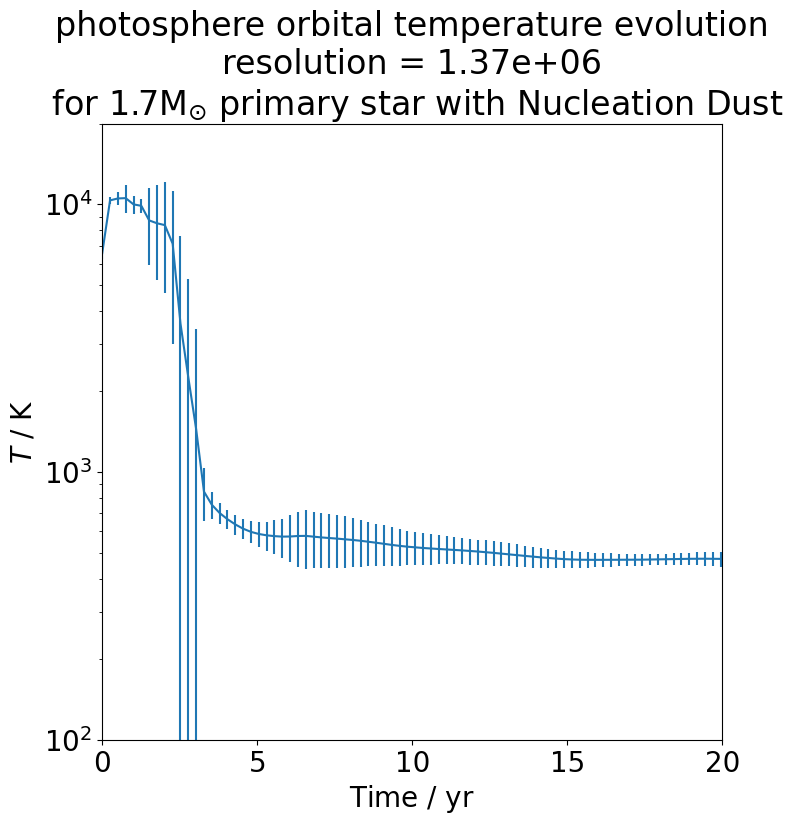

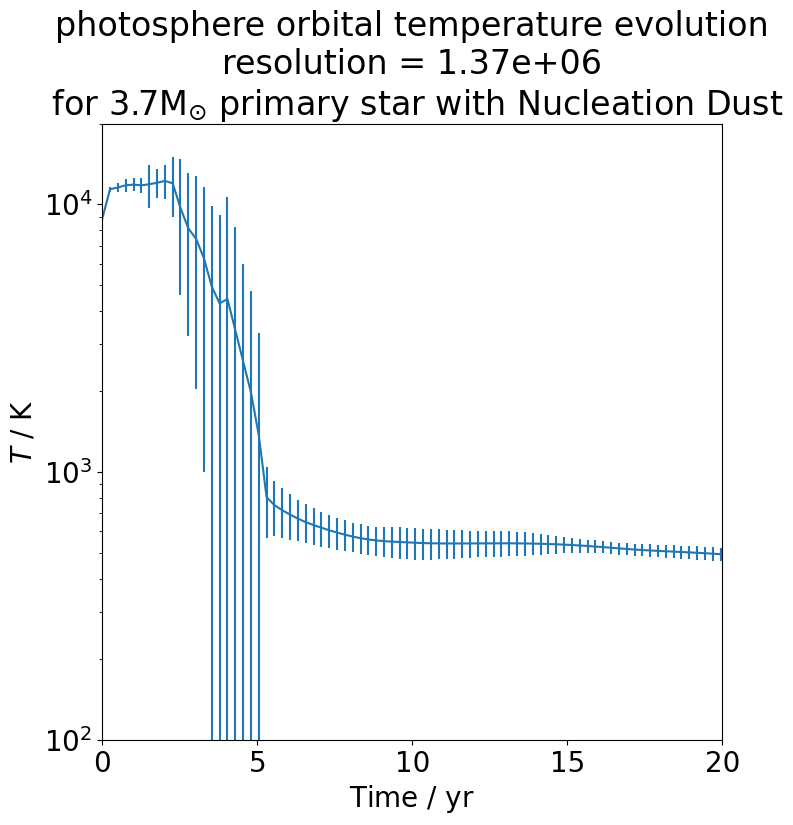

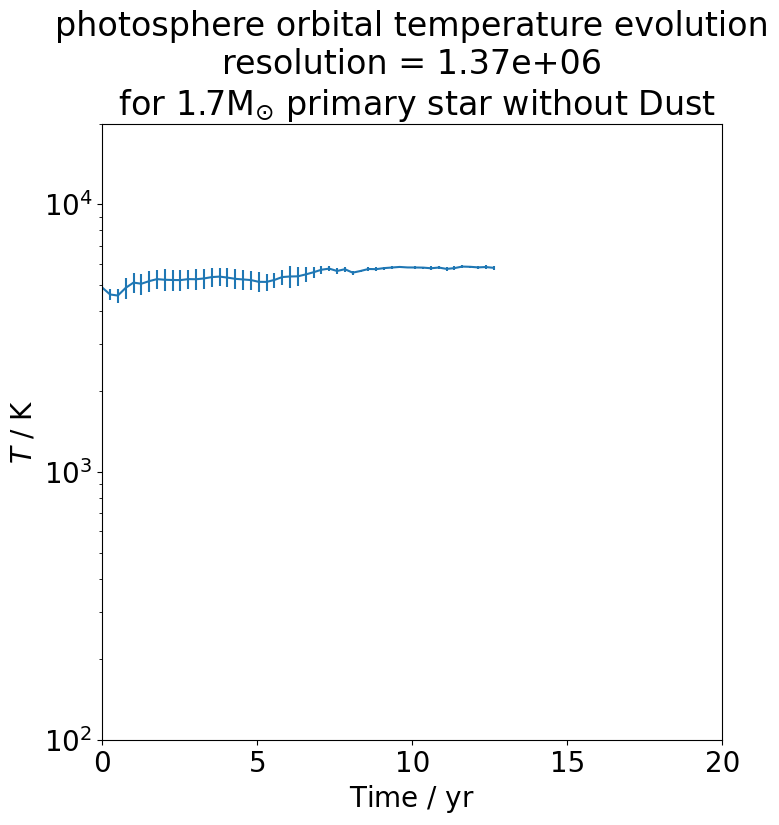

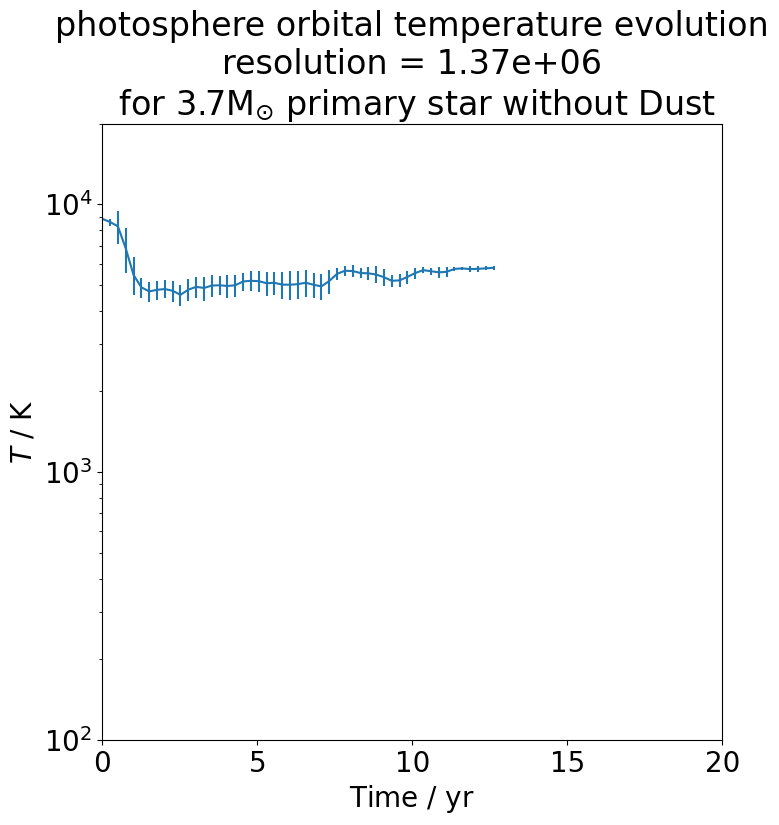

In [13]:
# plot temperature vs time



if __name__ == '__main__':
    
    for job_profile in JOB_PROFILES[:4]:
        job_name = job_profile['job_name']
        plot_title_suffix = job_profile['plot_title_suffix']

        plane_axes = 'xyz'
            
        fig, ax = plt.subplots(figsize=(8, 8))

        times_list  = []
        Ts_arr_list = []
        
        for file_index in job_profile['file_indexes']:

            job_filename = mupl.get_filename_phantom_dumps(job_name, file_index)

            # read data
            outfilename_noext = f"{job_filename}__photosphere-xsec__R1-{plane_axes}"
            with open(f"{outfilename_noext}.json", 'r') as f:
                photospheres = mupl.json_load(f)

            times_list.append(photospheres['dump_info']['time_yr'].to_value(unitsOut['time']))
            Ts_arr_list.append(photospheres['ph_vars']['T'].to_value(unitsOut['temp']))

        times = mupl.set_as_quantity(times_list, unitsOut['time'])
        Ts_arr = mupl.set_as_quantity_temperature(Ts_arr_list, unitsOut['temp'])

        Ts_val = np.average(Ts_arr, axis=1)
        Ts_err = np.std(Ts_arr, axis=1)

        #ax.semilogy(times, Ts_val, 'o')
        ax.errorbar(times, Ts_val, Ts_err)
        ax.semilogy()
        ax.set_xlabel(f"Time / {units.yr.to_string('latex_inline')}")
        ax.set_ylabel(f"$T$ / {units.K.to_string('latex_inline')}")
        ax.set_title(
            f"photosphere orbital temperature evolution\n" + \
            f"resolution = {photospheres['dump_info']['nparttot']:.2e}\n{plot_title_suffix}",
        )
        ax.set_ylim(1e2, 2e4)
        ax.set_xlim(0., 20.)
        # define job_folder_prefix
        for i in range(len(job_name)-1, -1, -1):
            if job_name[i] == path.sep:
                job_folder_prefix = job_name[:i]
                break
            else:
                job_folder_prefix = job_name
        outfilename = f"{job_folder_prefix}__tempEvo__{plane_axes}.png"
        fig.savefig(outfilename)

# Debug

In [5]:
# debug


do_debug = True


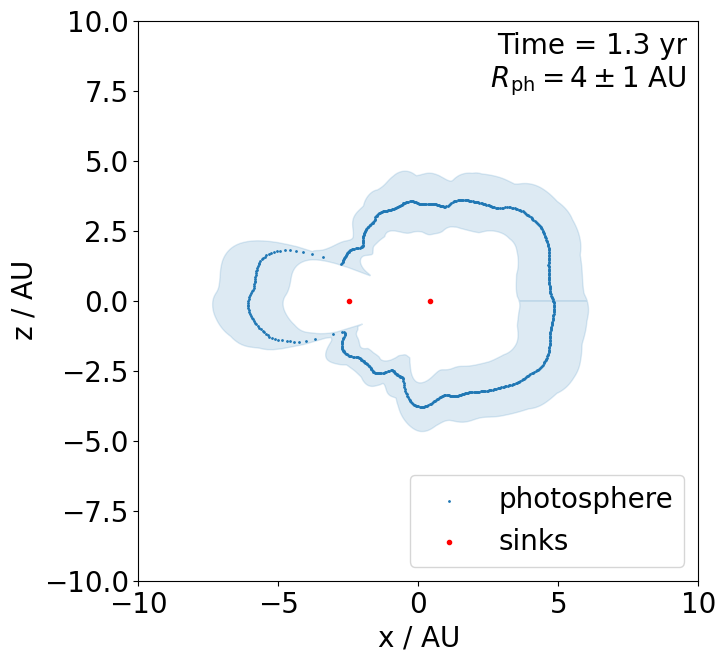

In [8]:
# debug

if __name__ == '__main__' and do_debug:
    photosphere_tau = 1.
    box_lim = 10
    xlim = (-box_lim, box_lim)
    ylim = xlim
    file_index = 500
    plane_axes = 'xzy'
    job_profile = JOB_PROFILES[3]
    job_name = job_profile['job_name']
    plot_title_suffix=job_profile['plot_title_suffix']
    job_filename = mupl.get_filename_phantom_dumps(job_name, file_index)
    outfilename_noext = f"{job_filename}__photosphere-xsec__R1-{plane_axes}"
    with open(f"{outfilename_noext}.json", 'r') as f:
        photospheres = mupl.readwrite.json_load(f)
    fig, ax, _ = plot_mpdf_photosphere_xsec(
                        photospheres,
                        job_name, file_index, plot_title_suffix,
                        do_legend=True, box_lim=box_lim, unitsOut=unitsOut,
                        outfilename_noext="",
                    )

    toUnitsOut = {}
    unitsOutTxt = {}
    unitsIn = {
        'dist': photospheres['units_cgs']['dist'] * units.cm,
    }
    for key in ['dist']:
        toUnitsOut[ key] = (1.*unitsIn[key]).to_value(unitsOut[key])
        unitsOutTxt[key] = unitsOut[key].to_string('latex')
    x = photospheres['ph_vars']['xsec_loc'][:, 0] * toUnitsOut['dist']
    y = photospheres['ph_vars']['xsec_loc'][:, 1] * toUnitsOut['dist']
    h = photospheres['ph_vars']['h'] * toUnitsOut['dist']
    R1 = photospheres['ph_vars']['R1'] * toUnitsOut['dist']
    xerr_combined = np.concatenate(
        (photospheres['ph_vars']['xsec_loc_min1h'][:, 0], photospheres['ph_vars']['xsec_loc_add1h'][::-1, 0])) * toUnitsOut['dist']
    yerr_combined = np.concatenate(
        (photospheres['ph_vars']['xsec_loc_min1h'][:, 1], photospheres['ph_vars']['xsec_loc_add1h'][::-1, 1])) * toUnitsOut['dist']
    fig.savefig(f"{outfilename_noext}.png")

In [7]:
if __name__ == '__main__' and do_debug:
    job_profile = JOB_PROFILES[3]
    job_name = job_profile['job_name']
    file_index = 500
    box_lim_Rsun = box_lim / toUnitsOut['dist']
    mpdf = mupl.MyPhantomDataFrames().read(job_name, file_index)
    sdf = mpdf.data['gas']
    sdf['T'] = sdf['Tdust']
    mpdf.calc_sdf_params(
        calc_params=['T', 'kappa'], verbose=3,
        calc_params_params={'ieos': None, 'overwrite': False, 'kappa_translate_from_cgs_units': False},)

    #mpdf.plot_render(rendered='h', xlim=(-box_lim_Rsun, box_lim_Rsun), ylim=(-box_lim_Rsun, box_lim_Rsun), norm=None)
    high_h_inds = np.where(photospheres['ph_vars']['h']>0.9*photospheres['ph_vars']['R1'])[0]
    print(f"{high_h_inds = }")
    sink_loc = [photospheres['dump_info']['sinks_locs'][ax][0].value for ax in 'xyz']
    xsec_loc = photospheres['ph_vars']['xsec_loc'][243] # 364
    pt_loc = np.array([xsec_loc[0].to_value(mpdf.units['dist']), sink_loc[1], xsec_loc[1].to_value(mpdf.units['dist'])])
    line = np.array([sink_loc,pt_loc])
    print(f"\n{line = }\n")
    neigh_inds = mupl.get_sph_close_pts_indices(loc=pt_loc, sdf=sdf)
    sdf_neigh_xyz = np.array(sdf[neigh_inds][['x', 'y', 'z']])
    neigh_dist = mupl.get_dist2_between_2pt(pt_loc, sdf_neigh_xyz)**0.5
    neigh_q = neigh_dist / sdf[neigh_inds]['h']
    print(f"{len(neigh_q) = }\n{neigh_q}")
    print(f"\n{pt_loc = }\n\n{mupl.get_closest_pt_on_line(sdf_neigh_xyz, line)=}\n\n{sdf_neigh_xyz = }")
    print(f"\n{sdf['T'][neigh_inds] = }")
    pts_on_line = mupl.get_closest_pt_on_line(np.array(sdf[['x', 'y', 'z']]), line)
    dist2 = mupl.get_dist2_between_2pt(np.array(sdf[['x', 'y', 'z']]), pts_on_line)
    line_neigh_inds = dist2 < sdf['h']**2
    print(f"\n{pts_on_line = }\n")
    pts_on_ray, dtaus, pts_order = mupl.get_optical_depth_by_ray_tracing_3D(sdf, line)
    print(f"\n{pts_on_ray[pts_order] = }\n")
    print(f"\n{sdf[['x', 'y', 'z', 'rho', 'h', 'T']].iloc[pts_order][:10] = }\n")
    print(f"\n{dtaus[pts_order][:10] = }\n")
    print(f"\n{sdf['h'].max()*toUnitsOut['dist'] = }\n")
    print(f"\n{max(photospheres['ph_vars']['h'])*toUnitsOut['dist'] = }\n")

    Note: Density column rho already exist in self.time = 25000.0.
*   Note: non-zero temperature column 'T' already in the datafile. Calc Cancelled.
high_h_inds = array([], dtype=int64)

line = array([[ 8.64024695e+01,  9.50612992e+00, -1.02552780e-01],
       [-4.99412731e+02,  9.50612992e+00,  3.98017046e+02]])

len(neigh_q) = 3
100773    1.860230
305654    1.678187
662483    1.799352
Name: h, dtype: float64

pt_loc = array([-499.41273093,    9.50612992,  398.0170463 ])

mupl.get_closest_pt_on_line(sdf_neigh_xyz, line)=array([[-727.94677689,    9.50612992,  553.32862355],
       [-381.36590461,    9.50612992,  317.79250597],
       [-383.97219292,    9.50612992,  319.56373768]])

sdf_neigh_xyz = array([[-948.51883228, -609.09200356,  228.76670013],
       [-406.91697345,  -56.68718339,  280.1952499 ],
       [-420.39345223,   45.07664519,  265.97148206]])

sdf['T'][neigh_inds] = 100773    4068.432264
305654    8193.400838
662483    8410.306684
Name: T, dtype: float64

pts_on_line = 

In [8]:
line

array([[ 8.64024695e+01,  9.50612992e+00, -1.02552780e-01],
       [-4.99412731e+02,  9.50612992e+00,  3.98017046e+02]])

In [10]:
if __name__ == '__main__' and do_debug:
    line = np.array(line)
    ray_unit_vec = mupl.get_ray_unit_vec(line)
    ray_0 = line[0]
    pts_on_ray_ordered = pts_on_ray[pts_order]
    pts_on_ray_ordered_t = np.sum((pts_on_ray_ordered - ray_0) * ray_unit_vec, axis=-1)
    taus_ordered = np.cumsum(dtaus[pts_order])
    photosphere, (pts_waypts, pts_waypts_t, taus_waypts) = mupl.get_photosphere_on_ray(
        pts_on_ray, dtaus, pts_order, sdf, line, photosphere_tau=photosphere_tau)
    print(photosphere)

{'is_found': True, 'loc': array([-500.07983956,    9.50612992,  398.47041286]), 'R1': 709.099363801675}


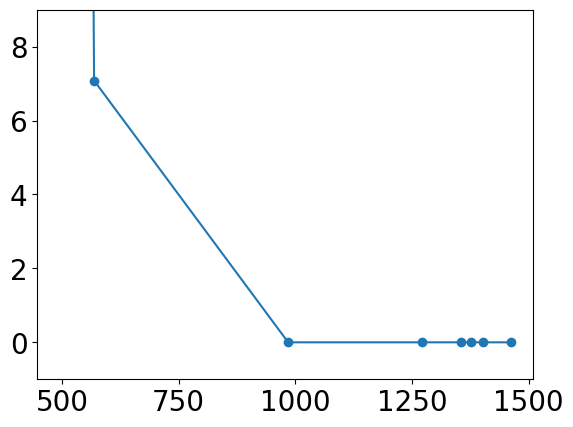

In [11]:
if __name__ == '__main__' and do_debug:
    npts = 15
    plt.plot(pts_on_ray_ordered_t[:npts], taus_ordered[:npts], 'o-')
    plt.ylim(-1., 9.)
    plt.savefig("temp.png")

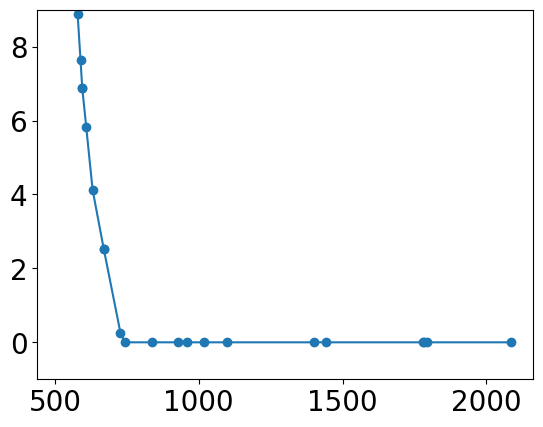

In [12]:
if __name__ == '__main__' and do_debug:
    plt.plot(pts_waypts_t[:npts*2], taus_waypts[:npts*2], 'o-')
    plt.ylim(-1., 9.)
    plt.savefig("temp.png")